# Tutorial 3: The Numerical Sandbox, Extension Experiment (Static mesh version)

**Romain Beucher**
Version 0.1

romain.beucher@unimelb.edu.au

The following notebook is an implementation of the Numerical Sandbox Extension Experiment similar to [Buiter et al., 2006](http://sp.lyellcollection.org/content/253/1/29). The test is commonly referred as one of the GEOMOD benchmarks and is used to test the large deformation viscous-plastic behaviour of geodynamic numerical codes.

The initial purpose of the GEOMOD numerical experiments was to compare results from analog and numerical experiments. It is not a numerical benchmark sensus-stricto.

The test has been implemented using Fantom in [Thieulot, 2011](http://linkinghub.elsevier.com/retrieve/pii/S0031920111001336) and more recently with Aspect in [Glerum et al., 2017](http://www.solid-earth-discuss.net/se-2017-9). 

![title](images/underworld.png)

Results for Underworld from this notebook

A | B
- | - 
![title](images/ExtensionA.png) | ![title](images/ExtensionB.png) 

Results for the extension experiment after 2cm extension (Buiter et al., 2006)

In [1]:
import UWGeodynamics as GEO

loaded rc file /workspace/user_data/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

In [3]:
velocity = 2.5 * u.centimeter / u.hour
model_length = 20. * u.centimeter
bodyforce = 1560 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / velocity
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

# Model Geometry

Set-up of the extension experiment. A viscous layer (PDMS, 10 x 0.5 cm) lies in the central part of the model on the base. The rest of the model consists of three ‘sand’ layers (only differing in colour). Extension is achieved by moving the right wall with the attached 10 cm long sheet outwards to the right.

<img src="images/Extension.png" width=800>

We use a uniform resolution of 0.2 cm (400 x 100 elements)

In [4]:
Model = GEO.Model(elementRes=(200, 50), 
                  minCoord=(0. * u.centimeter, -3.5 * u.centimeter), 
                  maxCoord=(20. * u.centimeter, 1.5 * u.centimeter), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

In [5]:
Model.outputDir="outputs_tutorial3"

In [7]:
#Model.add_visugrid(elementRes=(100, 25), 
#                   minCoord=(0. * u.centimeter, -3.5 * u.centimeter), 
#                   maxCoord=(20. * u.centimeter, 0.0 * u.centimeter))

# Add some Materials

Now that we have our "universe" (box, sand pit) ready, we need to fill it with some materials.
The *geodynamics* module is designed around that idea of materials, which are essentially a way to define physical properties across the Model domain.

A material (or a phase) is first defined by the space it takes in the box (its shape).

In [7]:
air = Model.add_material(name="Air", shape=GEO.shapes.Layer2D(top=Model.top, bottom=Model.bottom))
sand1 = Model.add_material(name="Sand1", shape=GEO.shapes.Layer2D(top=0.*u.centimeter, bottom=Model.bottom))
sand2 = Model.add_material(name="Sand2", shape=GEO.shapes.Layer2D(top=-1. * u.centimeter, bottom=-2. * u.centimeter))

vertices = [( 5.* u.centimeter, -3.0 * u.centimeter),
            (15.* u.centimeter, -3.0 * u.centimeter),
            (15.* u.centimeter, -3.5 * u.centimeter),
            ( 5.* u.centimeter, -3.5 * u.centimeter)]

silicon = Model.add_material(name="Silicon", shape=GEO.shapes.Polygon(vertices))


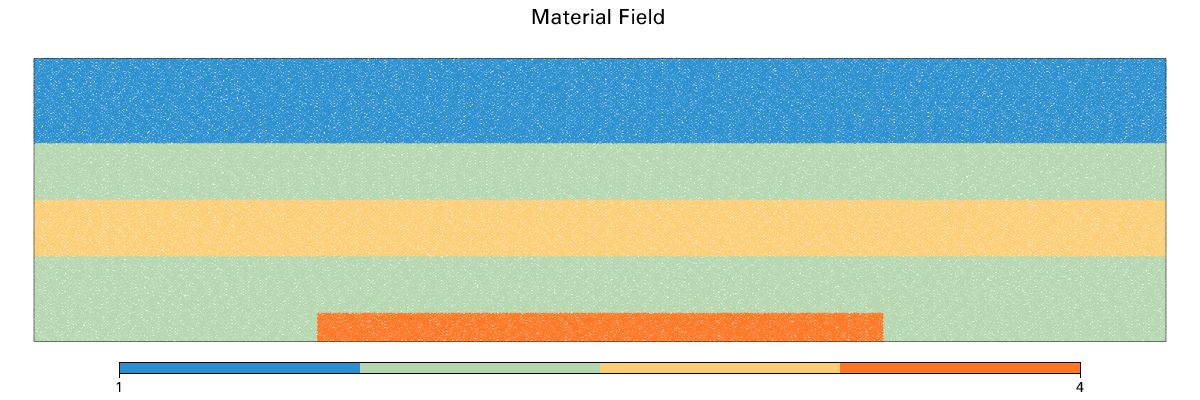

In [8]:
Fig = Model.plot.material(figsize=(1200,400), fn_size=2.0)

## Passive Tracers

In [9]:
import numpy as np

x = np.linspace(Model.minCoord[0], Model.maxCoord[0], 1000) * u.centimeter
interface1 = GEO.nd(sand1.top)
interface2 = GEO.nd(sand2.top)
interface3 = GEO.nd(sand2.bottom)

interface1 = Model.add_passive_tracers(name="Interface1", vertices=[x, interface1])
interface2 = Model.add_passive_tracers(name="Interface2", vertices=[x, interface2])
interface3 = Model.add_passive_tracers(name="Interface3", vertices=[x, interface3])


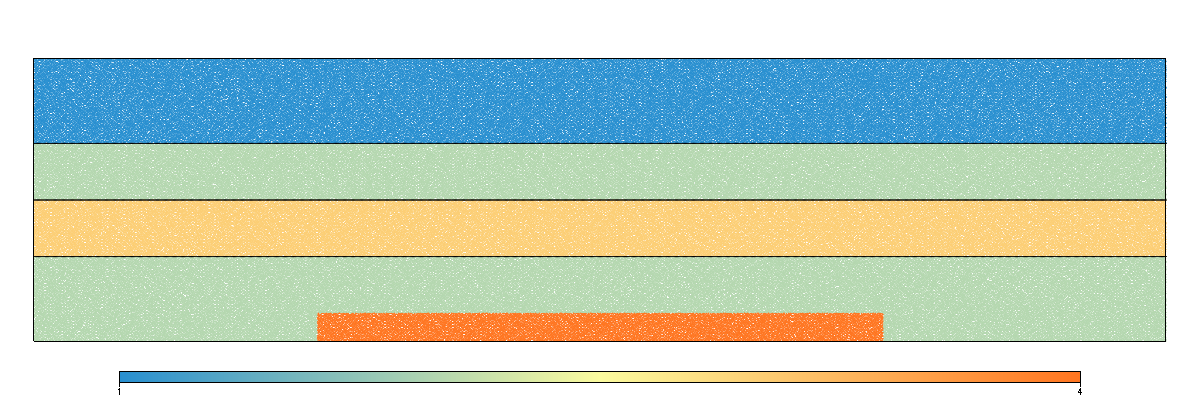

In [10]:
import glucifer
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(interface1.swarm, pointSize=2.0)
Fig.Points(interface2.swarm, pointSize=2.0)
Fig.Points(interface3.swarm, pointSize=2.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.show()

## Material properties

In [11]:
air.density = 10. * u.kilogram / u.metre**3
sand1.density = 1560. * u.kilogram / u.metre**3
sand2.density = 1560. * u.kilogram / u.metre**3
silicon.density = 965. * u.kilogram / u.metre**3

# Define Viscosities

Viscosities can be defined as a Quantity or a simple scalar value. It is also possible to load predefined rheologies from the rheology_library. 

The rheology library contains some commonly used rheologies stored in a python dictionary structure. We can list the keys defining the rheologies as follows:

In [12]:
# Assign function to materials
air.viscosity     = 1.0e2  * u.pascal * u.second
sand1.viscosity   = 1.0e13 * u.pascal * u.second
sand2.viscosity   = 1.0e13 * u.pascal * u.second
silicon.viscosity = 5.0e4  * u.pascal * u.second

# Define Plasticity

Plastic behavior is assigned using the same approach as for viscosities.

In [13]:
sandPlasticity = GEO.DruckerPrager(cohesion=10. * u.pascal,
                                     cohesionAfterSoftening=10. * u.pascal,
                                     frictionCoefficient=0.73,
                                     frictionAfterSoftening=0.60,
                                     minimumViscosity=1.0e2  * u.pascal * u.second)

In [14]:
sand1.plasticity = sandPlasticity
sand2.plasticity = sandPlasticity

# Boundary conditions

+ Basal points above the moving sheet are assigned the velocity of the sheet
+ Basal points to the left of the moving sheet are held fixed. 
+ The change in velocity at the basal velocity discontinuity is accommodated over 0.2 cm. 
+ The sides are not allowed to move vertically.

In [15]:
conditions = [(Model.x > GEO.nd(10.1 * u.centimetre), GEO.nd(2.5 * u.centimeter / u.hour)),
              (Model.x > GEO.nd(9.9 * u.centimetre), (Model.x - GEO.nd(9.9 * u.centimetre)) * GEO.nd(velocity) / GEO.nd(0.2 * u.centimetre)),
              (True, 0.0)]

Model.set_velocityBCs(left=[0 * u.centimeter / u.hour, None],
                      right=[2.5 * u.centimeter / u.hour, None],
                      bottom=[conditions, 0.0])

## Initialise Model

The model is initialize using the *init_model* method which will solve the initial steady state temperature field and the pressure field.

In [16]:
Model.minViscosity = 1.0e2 * u.pascal * u.second
Model.maxViscosity = 1.0e9 * u.pascal * u.second

In [17]:
Model.init_model()


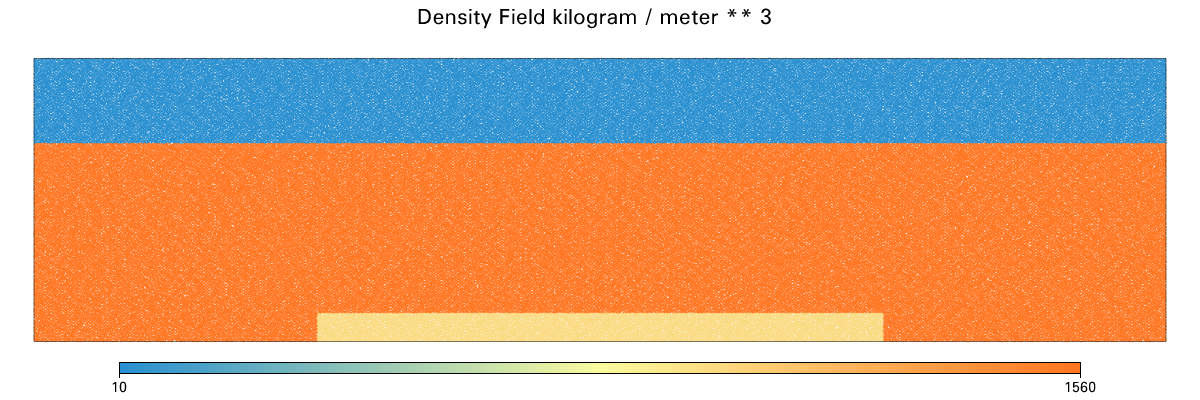

In [18]:
Fig = Model.plot.density(figsize=(1200,400), fn_size=2.)


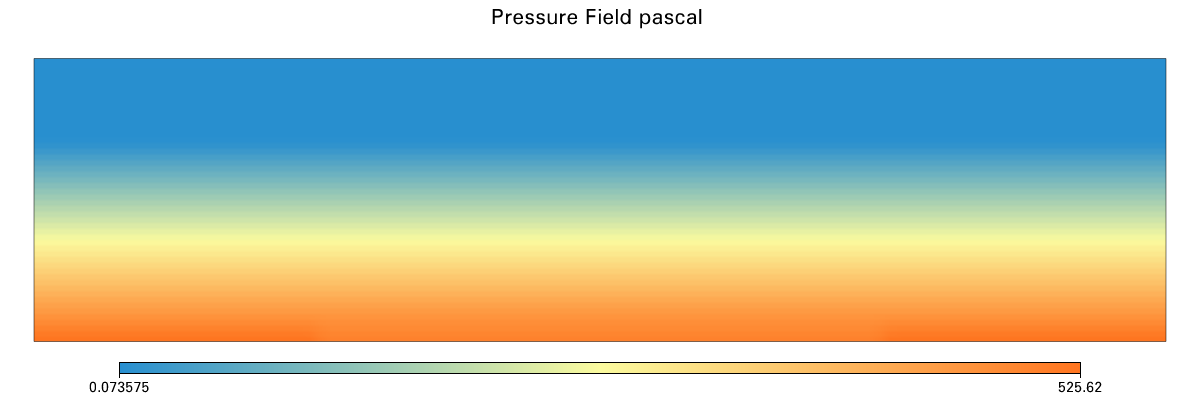

In [19]:
Fig = Model.plot.pressureField(onMesh=False, figsize=(1200,400), fn_size=2.)


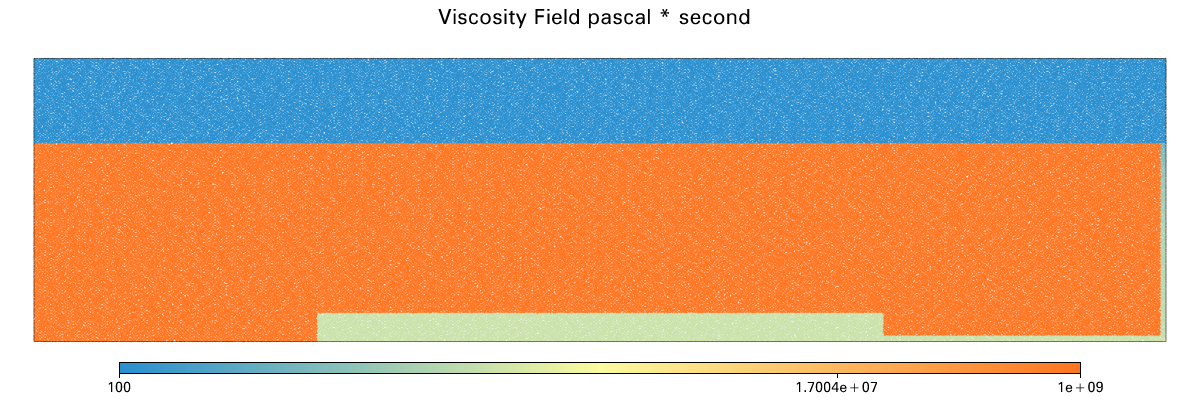

In [20]:
Fig = Model.plot.viscosity(figsize=(1200,400), fn_size=2.)


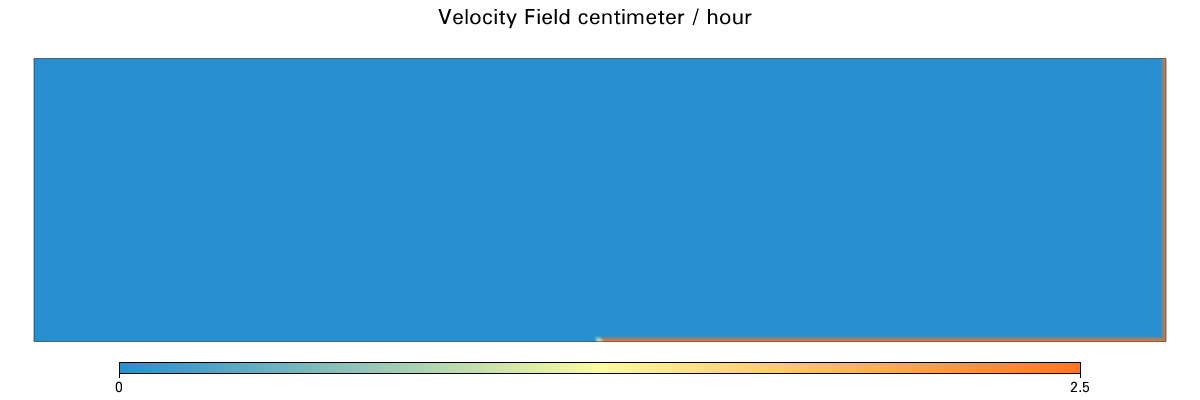

In [21]:
Fig = Model.plot.velocityField(figsize=(1200,400), units = u.centimetre / u.hour)

In [22]:
GEO.rcParams["solver"] = "mumps"
GEO.rcParams["penalty"] = 1e6

In [22]:
Model.run_for(1.0 * u.hours, checkpoint_interval=10 * u.minutes)

Time:  0.00997539012753 hour dt: 0.00997539012753 hour
Time:  0.0199520813999 hour dt: 0.00997669127238 hour
Time:  0.0299307598341 hour dt: 0.0099786784342 hour
Time:  0.0399127755901 hour dt: 0.00998201575595 hour
Time:  0.0498969690488 hour dt: 0.00998419345875 hour
Time:  0.0598840488283 hour dt: 0.00998707977948 hour
Time:  0.0698737406915 hour dt: 0.00998969186318 hour
Time:  0.0798644138892 hour dt: 0.00999067319774 hour
Time:  0.0898578429771 hour dt: 0.0099934290879 hour
Time:  0.0998523486656 hour dt: 0.00999450568855 hour
Time:  0.109847549424 hour dt: 0.00999520075806 hour
Time:  0.119840628879 hour dt: 0.00999307945561 hour
Time:  0.12983099933 hour dt: 0.00999037045073 hour
Time:  0.139829245035 hour dt: 0.00999824570457 hour
Time:  0.14982410363 hour dt: 0.0099948585949 hour
Time:  0.159819818773 hour dt: 0.00999571514392 hour
Time:  0.166666666667 hour dt: 0.00684684789323 hour
Time:  0.176658527905 hour dt: 0.00999186123821 hour
Time:  0.186652247419 hour dt: 0.0099937

1


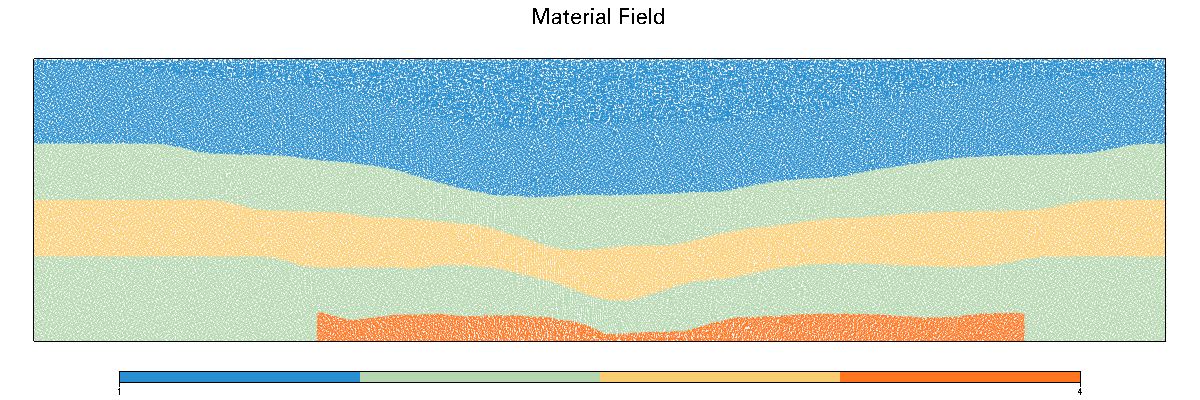

In [23]:
Fig = Model.plot.material(figsize=(1200,400), fn_size=2.)


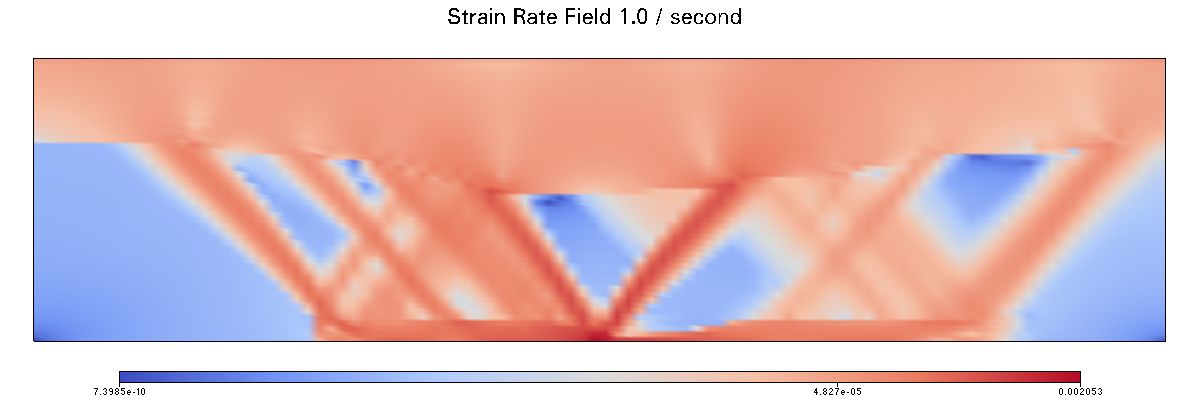

In [24]:
Fig = Model.plot.strainRate(onMesh=False, figsize=(1200,400), fn_size=2.)


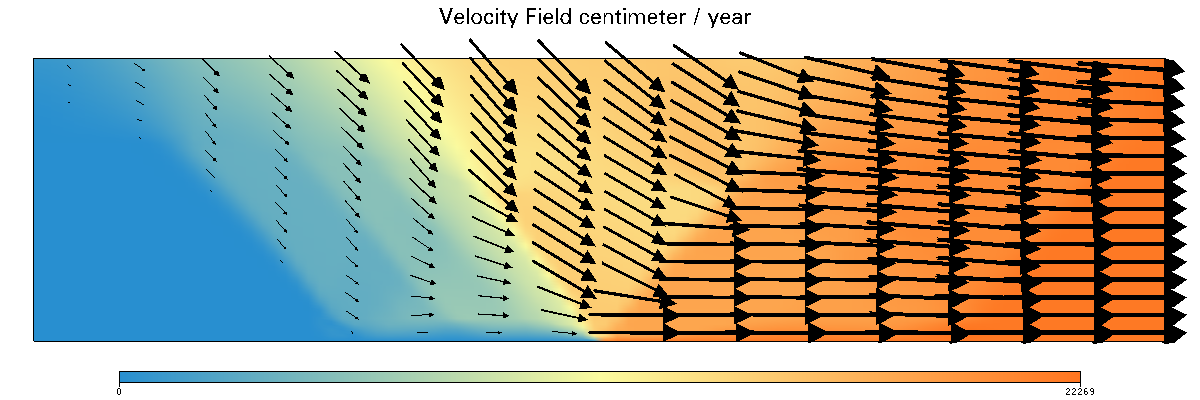

In [25]:
Fig = Model.plot.velocityField(onMesh=False, figsize=(1200,400), fn_size=2.)